# **Creating an Altmetric Regression Model**

In this notebook, I will be creating a regresion model to predict Altmetric Scores for documents, given the query and the document.  The query and the document will be represented as CoronaBERT embeddings.  The training and test labels will be log-transformed to dampen down the higher values.  I will be using a gbr regressor with default settings.

## **Setup**

In [1]:
import pickle
import gzip
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle?raw=true

with open('/content/coronaBERT_doc_embeddings.pickle?raw=true', 'rb') as f:
  doc_embeddings = pickle.load(f)

--2022-03-16 15:02:31--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle [following]
--2022-03-16 15:02:31--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle [following]
--2022-03-16 15:02:31--  https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/ma

In [5]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
with open('/content/coronaBERT_query_embeddings.pickle?raw=true', 'rb') as f:
  query_embeddings = pickle.load(f)

--2022-03-16 15:07:16--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle [following]
--2022-03-16 15:07:17--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle [following]
--2022-03-16 15:07:17--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/ma

In [6]:
!wget https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/training_validation_data.csv
training_qrels = pd.read_csv('/content/training_validation_data.csv').drop(columns=['Unnamed: 0'])

--2022-03-16 15:07:20--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/training_validation_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 901346 (880K) [text/plain]
Saving to: ‘training_validation_data.csv’

training_validation 100%[===================>] 880.22K  --.-KB/s    in 0.07s   

2022-03-16 15:07:21 (11.8 MB/s) - ‘training_validation_data.csv’ saved [901346/901346]



In [7]:
!wget https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/testing_data.csv
test_qrels = pd.read_csv('/content/testing_data.csv').drop(columns=['Unnamed: 0'])

--2022-03-16 15:07:21--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/testing_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448853 (438K) [text/plain]
Saving to: ‘testing_data.csv’

testing_data.csv    100%[===================>] 438.33K  --.-KB/s    in 0.07s   

2022-03-16 15:07:21 (6.30 MB/s) - ‘testing_data.csv’ saved [448853/448853]



In [8]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz?raw=true

with gzip.open('/content/altmetric_for_CORD-19.json.gz?raw=true', 'r') as f:
  cc = f.read()

  json_str = cc.decode('utf-8')
  data = json.loads(json_str)

--2022-03-16 15:07:23--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz [following]
--2022-03-16 15:07:23--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz [following]
--2022-03-16 15:07:23--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/altmetric_for_COR

In [9]:
#concatenate the query and document embeddings for every row in the training qrels

training_queries = list(training_qrels['qid'])
training_docnos = list(training_qrels['docno'])

X_train = []
y_train = []


for query, docno in zip(training_queries, training_docnos):
  
  try:
    query_embedding = query_embeddings[str(query)]
    doc_embedding = doc_embeddings[docno]
    input = np.concatenate([query_embedding, doc_embedding])

    X_train.append(input)

    if docno in data:
      if data[docno] is not None:
        y_train.append(data[docno]['score'])
      else:
        y_train.append(0)
    else:
      y_train.append(0)
    

  except:
    print("No embedding")
    




No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding


In [10]:
#concatenate the query and document embeddings for every row in the training qrels

testing_queries = list(test_qrels['qid'])
testing_docnos = list(test_qrels['docno'])

X_test = []
y_test = []


for query, docno in zip(testing_queries, testing_docnos):
  
  try:
    query_embedding = query_embeddings[str(query)]
    doc_embedding = doc_embeddings[docno]
    input = np.concatenate([query_embedding, doc_embedding])

    X_test.append(input)

    if docno in data:
      if data[docno] is not None:
        y_test.append(data[docno]['score'])
      else:
        y_test.append(0)
    else:
      y_test.append(0)
    

  except:
    print("No embedding")
    



## **Log Transform the Labels**

In [13]:
y_train_copy = y_train.copy()

In [14]:
for i in range(len(y_train_copy)):
  if y_train_copy[i]==0:
    y_train_copy[i] += 1

In [15]:
for i in range(len(y_train_copy)):
  y_train_copy[i] = np.log(y_train_copy[i])

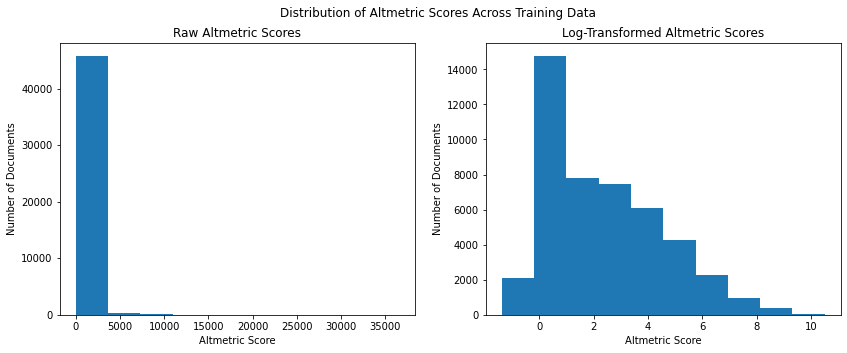

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Distribution of Altmetric Scores Across Training Data")
ax[0].hist(y_train)
ax[0].set_title("Raw Altmetric Scores")
ax[0].set_xlabel("Altmetric Score")
ax[0].set_ylabel("Number of Documents")
ax[1].hist(y_train_copy)
ax[1].set_title("Log-Transformed Altmetric Scores")
ax[1].set_xlabel("Altmetric Score")
ax[1].set_ylabel("Number of Documents")
fig.savefig("altmetric_distribution.pdf", format="pdf", bbox_inches="tight") 

## **Train the model and make predictions**

In [ ]:
gbr = GradientBoostingRegressor(verbose=True)
gbr = gbr.fit(X_train, y_train)
predictions = gbr.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1           4.9606           32.82m
         2           4.9251           29.92m
         3           4.8907           28.74m
         4           4.8630           27.96m
         5           4.8339           27.39m
         6           4.8066           26.98m
         7           4.7829           26.78m
         8           4.7591           26.37m
         9           4.7397           26.05m
        10           4.7199           25.75m
        20           4.5781           23.75m
        30           4.4771           20.64m
        40           4.4002           17.56m
        50           4.3284           14.57m
        60           4.2623           11.65m
        70           4.2032            8.72m
        80           4.1553            5.81m
        90           4.1074            2.91m
       100           4.0606            0.00s


In [ ]:
y_predicted = np.exp(predictions)

## **Evaluate the Model Performance**

In [ ]:
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(rmse)

12.895071697682921


## **Evaluation**

In [ ]:
predictions = gbr.predict(X_test)

In [ ]:
y_predicted = np.exp(predictions)

In [ ]:
true_vals = np.array(y_test)

In [ ]:
x_labels = range(len(true_vals))
x_labels

range(0, 23151)

In [ ]:
differences = np.abs(true_vals-y_predicted)

(array([2.2729e+04, 3.9800e+02, 1.3000e+01, 6.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([8.82624493e-04, 3.38060665e+01, 6.76112504e+01, 1.01416434e+02,
        1.35221618e+02, 1.69026802e+02, 2.02831986e+02, 2.36637170e+02,
        2.70442354e+02, 3.04247537e+02, 3.38052721e+02]),
 <a list of 10 Patch objects>)

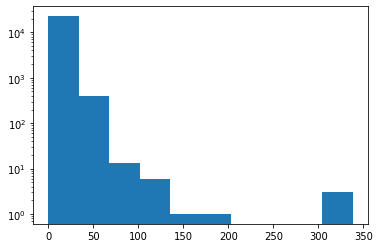

In [ ]:
plt.hist(differences, log=True)